## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Download modules

In [2]:
class Module(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput

    def updateOutput(self, input):
        pass

    def updateGradInput(self, input, gradOutput):
        pass

    def accGradParameters(self, input, gradOutput):
        pass

    def zeroGradParameters(self):
        pass

    def getParameters(self):
        return []

    def getGradParameters(self):
        return []

    def train(self):
        self.training = True

    def evaluate(self):
        self.training = False

    def __repr__(self):
        return "Module"


In [3]:
class Sequential(Module):
       
    def __init__(self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        self.modules.append(module)

    def removebyidx(self, idx):
        self.modules = self.modules[:idx]

    def updateOutput(self, input):

        self.output = input
        for module in self.modules:
            self.output = module.forward(self.output)
        return self.output

    def backward(self, input, gradOutput):
        modules_inputs = [input] + [module.output for module in self.modules[:-1]]

        self.gradInput = gradOutput
        for module, module_input in zip(self.modules[::-1], modules_inputs[::-1]):
            self.gradInput = module.backward(module_input, self.gradInput)

        return self.gradInput

    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        self.training = False
        for module in self.modules:
            module.evaluate()


In [4]:
class Linear(Module):
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
       
        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, _input):
        self.output = np.matmul(_input, self.W.T) + self.b
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        self.gradInput = np.matmul(gradOutput, self.W)
        return self.gradInput
    
    def accGradParameters(self, _input, gradOutput):
        self.gradW += np.matmul(gradOutput.T, _input)
        self.gradb += np.sum(gradOutput, axis=0)
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

In [5]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()
    
    def updateOutput(self, input):
        input = np.subtract(input, input.max(axis=1, keepdims=True))
        self.output = np.exp(input) / np.sum(np.exp(input), axis = 1, keepdims=True)
        return self.output


    def updateGradInput(self, input, gradOutput):
        first_repr = np.einsum('bi,bj->bij', self.output ,self.output)
        sec_repr = np.einsum('bi,ij->bij', self.output, np.eye(input.shape[1],input.shape[1]))
        third_repr = sec_repr - first_repr
        self.gradInput = np.einsum('bij,bj->bi',third_repr, gradOutput)
        return self.gradInput


    def __repr__(self):
        return "SoftMax"

In [6]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()

    def softmax(self, input):
        res = np.subtract(input, input.max(axis=1, keepdims=True))
        exps = np.exp(res)
        res = exps / np.sum(exps, axis=1, keepdims=True)
        return res

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        log_of_sum = np.log(np.sum(np.exp(self.output), axis=-1, keepdims=True))
        self.output -= log_of_sum
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        sm = self.softmax(input)
        derivatives = np.subtract(np.identity(input.shape[-1])[None, :, :], sm[:, None, :])
        self.gradInput = []
        for i in range(derivatives.shape[0]):
            self.gradInput.append(gradOutput[i] @ derivatives[i])
        self.gradInput = np.array(self.gradInput)
        return self.gradInput
    def __repr__(self):
        return "LogSoftMax"

In [7]:
class BatchNormalization(Module):
    EPS = 1e-6
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = 0 
        self.moving_variance = 0
        
    def updateOutput(self, input):
        # use self.EPS please
        if (self.training == True):
            self.mean = np.mean(input, axis=0, keepdims=True)
            self.var = np.var(input, axis=0, keepdims=True)
            self.moving_mean = self.moving_mean * self.alpha + self.mean * (1 - self.alpha)
            self.moving_variance = self.moving_variance * self.alpha + self.var * (1 - self.alpha)
            self.output = (input - self.mean) / np.sqrt(self.var + self.EPS)
        else:
            self.output = (input - self.moving_mean) / np.sqrt(self.moving_variance + self.EPS)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = input.shape[0] * gradOutput
        self.gradInput -= np.sum(gradOutput, axis=0, keepdims=True)
        self.gradInput -= self.output * np.sum(gradOutput * self.output, axis=0, keepdims=True)
        self.gradInput = 1/(input.shape[0] * np.sqrt(self.var + self.EPS)) * self.gradInput
        
        return self.gradInput
    
    def __repr__(self):
        return "BatchNormalization"

In [8]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)
        
        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output
        
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)
    
    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)
        
    def getParameters(self):
        return [self.gamma, self.beta]
    
    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]
    
    def __repr__(self):
        return "ChannelwiseScaling"

In [9]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p
        self.mask = None
        
    def updateOutput(self, input):
        if (self.training == True):
            if (self.p == 0.0):
                self.mask = np.ones_like(input)
            else:
                self.mask = np.random.binomial(1, 1 - self.p, input.shape)
            self.output = np.multiply(input, self.mask) / (1 - self.p)
        else:
            self.output = input
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.mask / (1 - self.p)
        return self.gradInput
        
    def __repr__(self):
        return "Dropout"

In [10]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput
    
    def __repr__(self):
        return "ReLU"

In [11]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()
            
        self.slope = slope
        
    def updateOutput(self, input):
        self.output = np.where(input <= 0, self.slope * input, input)
        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        input_copy = np.where(input > 0, 1, input)
        input_copy = np.where(input_copy < 0, self.slope, input_copy)
        self.gradInput = np.multiply(gradOutput, input_copy)
        return self.gradInput
    
    def __repr__(self):
        return "LeakyReLU"

In [12]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()
        
        self.alpha = alpha
        
    def updateOutput(self, input):
        self.output = np.where(input <= 0, self.alpha * (np.exp(input) - 1), input)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        input_copy = np.where(input > 0, 1, input)
        input_copy = np.where(input_copy <= 0, self.alpha * np.exp(input_copy), input_copy)
        self.gradInput = np.multiply(input_copy, gradOutput)
        return self.gradInput
    
    def __repr__(self):
        return "ELU"

In [13]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()
    
    def updateOutput(self, input):
        self.output = np.log(1 + np.exp(input))
        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.exp(input)/(1 + np.exp(input)) * gradOutput
        return self.gradInput
    
    def __repr__(self):
        return "SoftPlus"

In [14]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        
    def forward(self, input, target):
        return self.updateOutput(input, target)

    def backward(self, input, target):
        return self.updateGradInput(input, target)
    
    def updateOutput(self, input, target):
        return self.output

    def updateGradInput(self, input, target):
        return self.gradInput   

    def __repr__(self):
        return "Criterion"

In [15]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()
        
    def updateOutput(self, input, target):   
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output 
 
    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

In [16]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()
        
    def updateOutput(self, input, target): 
        
        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
        self.output = - np.sum(np.multiply(target, np.log(input_clamp)))/input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        
        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
                
        self.gradInput = - (target / input_clamp)/input.shape[0]
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterionUnstable"

In [17]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()
        
    def updateOutput(self, input, target): 
        self.output = - np.sum(np.multiply(target, input))/input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput = - target/input.shape[0]
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterion"

In [18]:
def sgd_momentum(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})
    var_index = 0 
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            
            old_grad = state['accumulated_grads'].setdefault(var_index, np.zeros_like(current_grad))
            
            np.add(config['momentum'] * old_grad, config['learning_rate'] * current_grad, out = old_grad)
            
            current_var -= old_grad
            var_index += 1     

In [19]:
def adam_optimizer(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('m', {})  # first moment vars
    state.setdefault('v', {})  # second moment vars
    state.setdefault('t', 0)   # timestamp
    state['t'] += 1
    for k in ['learning_rate', 'beta1', 'beta2', 'epsilon']:
        assert k in config, config.keys()
    
    var_index = 0 
    lr_t = config['learning_rate'] * np.sqrt(1 - config['beta2']**state['t']) / (1 - config['beta1']**state['t'])
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            var_first_moment = state['m'].setdefault(var_index, np.zeros_like(current_grad))
            var_second_moment = state['v'].setdefault(var_index, np.zeros_like(current_grad))
            
            # update `current_var_first_moment`, `var_second_moment` and `current_var` values
            np.add(config['beta1'] * var_first_moment, (1 - config['beta1']) * current_grad, out=var_first_moment)
            np.add(config['beta2'] * var_second_moment, (1 - config['beta2']) * np.multiply(current_grad, current_grad), out=var_second_moment)
            current_var -= lr_t * var_first_moment / (np.sqrt(var_second_moment) + config['epsilon'])
            
            # small checks that you've updated the state; use np.add for rewriting np.arrays values
            assert var_first_moment is state['m'].get(var_index)
            assert var_second_moment is state['v'].get(var_index)
            var_index += 1


# Main part of lab

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

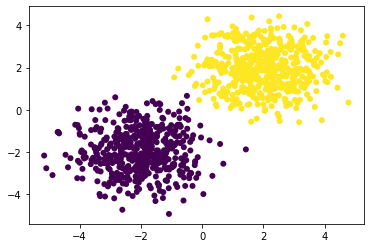

In [21]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [22]:
net = Sequential()
net.add(Linear(2, 4))
net.add(Linear(4, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 4
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [23]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 500

In [24]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

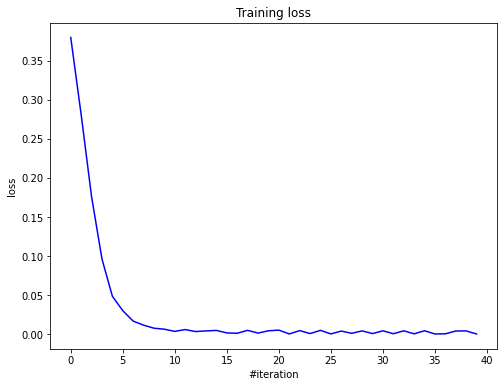

Current loss: 0.000340


In [25]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [26]:
import gzip
import pickle
import torch
f = gzip.open('mnist.pkl.gz', 'rb')
if sys.version_info < (3,):
    data = pickle.load(f)
else:
    data = pickle.load(f, encoding='bytes')
f.close()
(x_train, y_train), (x_test, y_test) = data

x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

One-hot encode the labels first.

In [27]:
import torch
import torch.nn.functional as F

y_train_unencoded = y_train
y_train = F.one_hot(torch.tensor(y_train.tolist())).numpy()

y_test_unencoded = y_test
y_test =  F.one_hot(torch.tensor(y_test.tolist())).numpy()

In [28]:
class model_collection():

    def __init__(self,optimizer_config = {'learning_rate' : 1e-4, 'momentum': 0.9}):
        self.optimizer_config = optimizer_config
        self.neural_networks = []
        self.names = []
        self.criterion = ClassNLLCriterion()

    def add_nn(self, shapes, activation, normalization = False):
        if normalization == False:
            self.names.append(activation)
        else:
            self.names.append(activation+'_normalization')
        net = Sequential()
        if normalization == False:
            if activation == 'relu':
                for i in range(1, len(shapes)):
                    net.add(Linear(shapes[i - 1], shapes[i]))
                    if i == len(shapes) - 1:
                        pass
                    else:
                        net.add(ReLU())

            if activation == 'elu':
                for i in range(1, len(shapes)):
                    net.add(Linear(shapes[i - 1], shapes[i]))
                    if i == len(shapes) - 1:
                        pass
                    else:
                        net.add(ELU())
                    
            
            if activation == 'softplus':
                for i in range(1, len(shapes)):
                    net.add(Linear(shapes[i - 1], shapes[i]))
                    if i == len(shapes) - 1:
                        pass
                    else:
                        net.add(SoftPlus())

            if activation == 'leakyrelu':
                for i in range(1, len(shapes)):
                    net.add(Linear(shapes[i - 1], shapes[i]))
                    if i == len(shapes) - 1:
                        pass
                    else:
                        net.add(LeakyReLU())

            net.add(LogSoftMax())

        else:
            if activation == 'relu':
                for i in range(1, len(shapes)):
                    net.add(Linear(shapes[i - 1], shapes[i]))
                    if i == len(shapes) - 1:
                        pass
                    else:
                        net.add(BatchNormalization(alpha=0.5))
                        net.add(ChannelwiseScaling(n_out=shapes[i]))
                        net.add(ReLU())

            if activation == 'elu':
                for i in range(1, len(shapes)):
                    net.add(Linear(shapes[i - 1], shapes[i]))
                    if i == len(shapes) - 1:
                        pass
                    else:
                        net.add(BatchNormalization(alpha=0.5))
                        net.add(ChannelwiseScaling(n_out=shapes[i]))
                        net.add(ELU())
            
            if activation == 'softplus':
                for i in range(1, len(shapes)):
                    net.add(Linear(shapes[i - 1], shapes[i]))
                    if i == len(shapes) - 1:
                        pass
                    else:
                        net.add(BatchNormalization(alpha=0.5))
                        net.add(ChannelwiseScaling(n_out=shapes[i]))
                        net.add(SoftPlus())

            if activation == 'leakyrelu':
                for i in range(1, len(shapes)):
                    net.add(Linear(shapes[i - 1], shapes[i]))
                    if i == len(shapes) - 1:
                        pass
                    else:
                        net.add(BatchNormalization(alpha=0.5))
                        net.add(ChannelwiseScaling(n_out=shapes[i]))
                        net.add(LeakyReLU())

            net.add(LogSoftMax())
        self.neural_networks.append(net)

    def train_all_models(self,models, x_train, y_train, x_test, y_test, optimizers, n_epoch = 15,loglos = False):
        # define list with loss of each models
        loss_models = []
        # Iter by models and by optimizers for models
        for num_net in range(len(models)):
            optimizer = optimizers[num_net]
            if optimizer == adam_optimizer:
                self.optimizer_config = {'learning_rate' : 1e-3, 'beta1':0.1, 'beta2':0.95, 'epsilon': 1e-6}
            optimizer_state = {}
#######################################################
            # define list with losses each model
            loss_model = []
            # iter by epoh
            for i in range(n_epoch):
                # TRAIN
                models[num_net].train()
                # Iter by batch
                for x_batch, y_batch in get_batches((x_train, y_train), 200):

                    models[num_net].zeroGradParameters()
                    # Forward
                    predictions = models[num_net].forward(x_batch)
                    self.criterion.forward(predictions, y_batch)
                    # Backward
                    dp = self.criterion.backward(predictions, y_batch)
                    models[num_net].backward(x_batch, dp)
                    
                    optimizer(models[num_net].getParameters(), 
                            models[num_net].getGradParameters(),
                            self.optimizer_config,
                            optimizer_state) 
                # EVALUATE
                models[num_net].evaluate()
                loss = self.criterion.forward(models[num_net].forward(x_test), y_test)
                loss_model.append(loss) 
            # add model's losses to list of losses
            loss_models.append(loss_model)    
#########################################################
        if loglos:
            new_loss_models = []
            for loss_model in loss_models:
                loss_model = np.log(loss_model)
                new_loss_models.append(loss_model)
            loss_models = new_loss_models
        plt.figure(figsize=(16, 12))
        plt.title("Test loss")
        plt.xlabel("№ iteration")
        plt.ylabel("losses")
        plt.yticks()
        plt.grid()
        legend = []
        for i in range(len(loss_models)):
            plt.plot(loss_models[i], label = self.names[i])
            legend.append(self.names[i])
        plt.legend(legend)
        plt.show()

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.

In [29]:
models = model_collection({'learning_rate' : 1e-4, 'momentum': 0.9})
models.add_nn([784,800,10],'relu')
models.add_nn([784,800,10],'elu')
models.add_nn([784,800,10],'leakyrelu')
models.add_nn([784,800,10],'softplus')

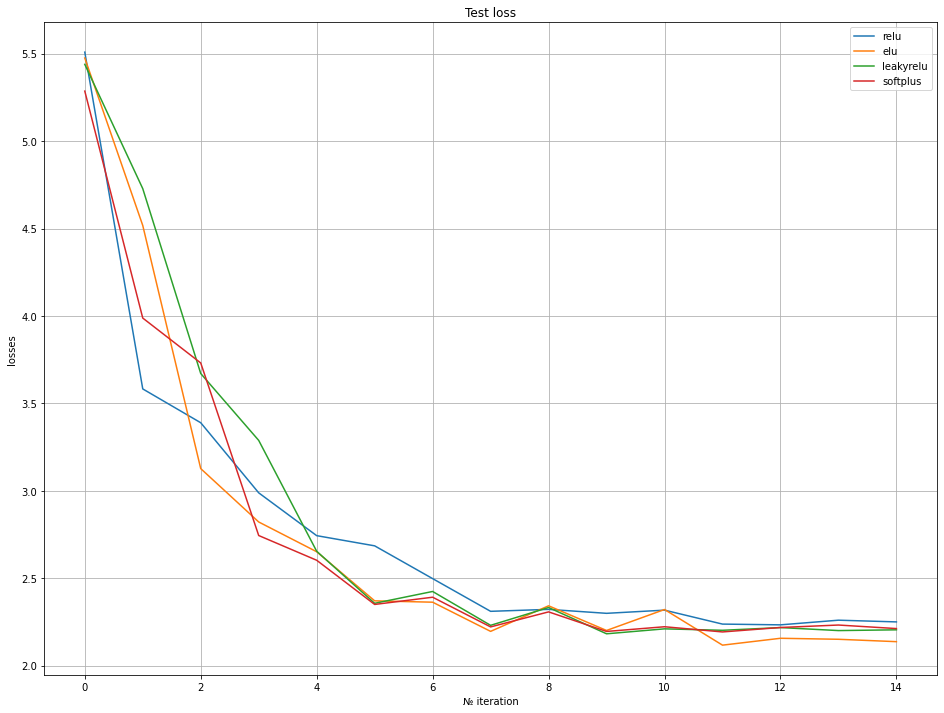

In [30]:
models.train_all_models(models.neural_networks,x_train[:2000], y_train[:2000],x_test[:2000], y_test[:2000],
                        [sgd_momentum for i in range(len(models.neural_networks))])

As we can see, all functions work fine and almost the same in this case

- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.

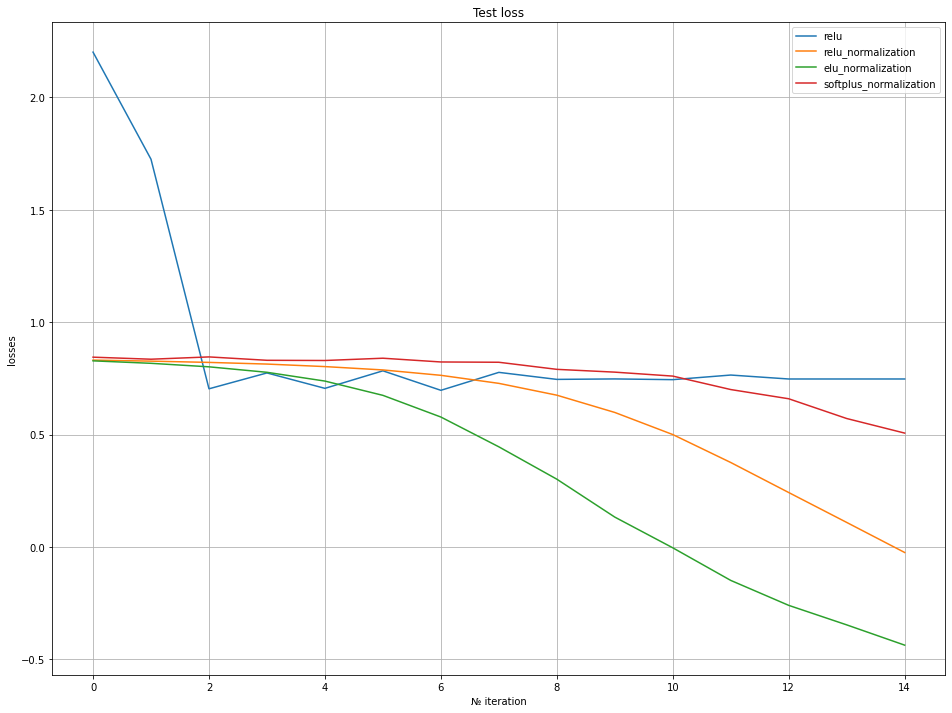

In [31]:
models = model_collection({'learning_rate' : 1e-2, 'momentum': 0.9})
models.add_nn([784,800,10],'relu')
# models.add_nn([784,800,10],'elu')
# models.add_nn([784,800,10],'leakyrelu')
# models.add_nn([784,800,10],'softplus')

models.add_nn([784,800,10],'relu',True)
models.add_nn([784,800,10],'elu',True)
# models.add_nn([784,800,10],'leakyrelu',True)
models.add_nn([784,800,10],'softplus',True)

models.train_all_models(models.neural_networks, x_train[:3000], y_train[:3000],x_test[:3000], y_test[:3000],
                        [sgd_momentum for i in range(len(models.neural_networks))],loglos=True)

The graph is presented in a logarithmic scale. In general, we see that normalization gives a smaller error + converges better

- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

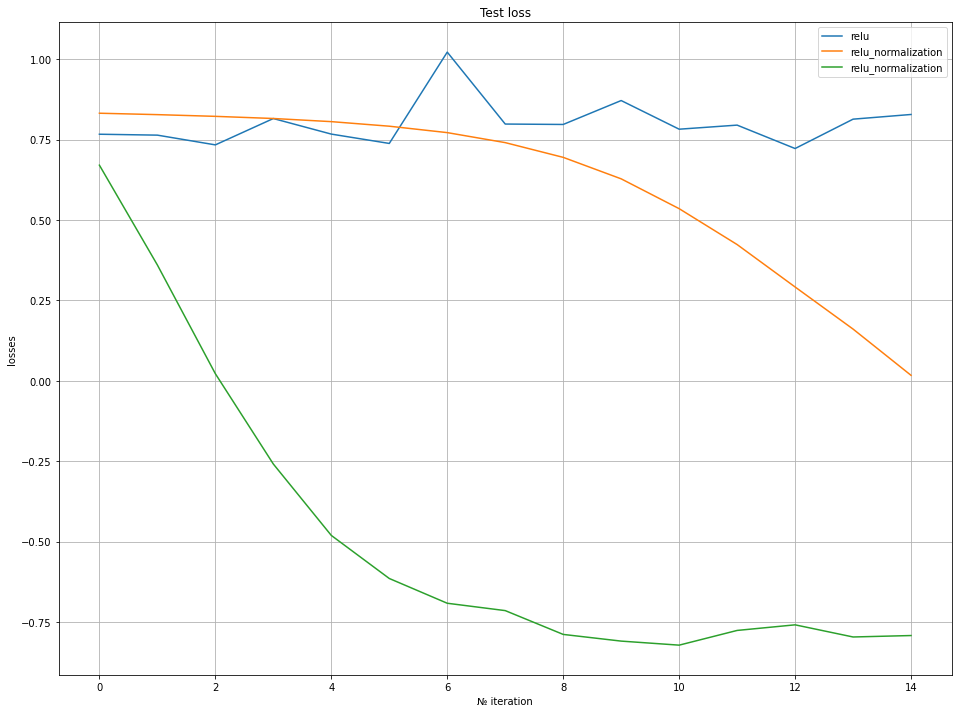

In [32]:
models = model_collection({'learning_rate' : 1e-2, 'momentum': 0.9})

models.add_nn([784,800,10],'relu')
models.add_nn([784,800,10],'relu',True)
models.add_nn([784,800,10],'relu',True)

models.train_all_models(models.neural_networks, x_train[:3000], y_train[:3000],x_test[:3000], y_test[:3000],
                        [sgd_momentum, sgd_momentum, adam_optimizer],loglos=True)

It was not possible to sign normally, but I will list from top to bottom - relu to sgd (blue), relu+batchnorm to sgd (willing),relu+batchnorm+adam (green). As we can see, the last combination converges faster and shows the best result

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Да, батч норм дает большой прирост качества (это лучше заметно на нелогафмированной шкале)

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

Let's just use the standard model

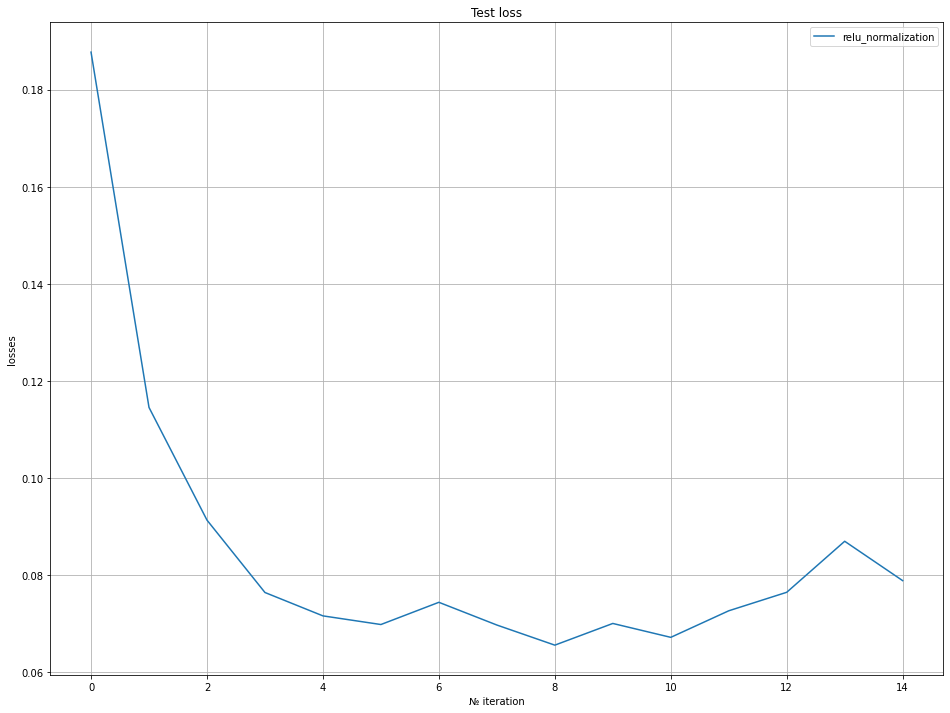

In [33]:
final_model = model_collection()
final_model.add_nn([784,800,10],'relu',True)

final_model.train_all_models(final_model.neural_networks, x_train, y_train ,x_test, y_test,
                        [adam_optimizer],n_epoch=15)

In [34]:
model = final_model.neural_networks[0]
model.evaluate()
predictions = model.forward(x_test)

In [35]:
ensembled_prediction = np.argmax(predictions, axis=1)
accuracy = (ensembled_prediction == y_test_unencoded).mean()
print(f"Acuracy is {100*accuracy:.3f}%")

Acuracy is 98.010%


As we can see, it gives a good result

Print here your accuracy on test set. It should be around 90%.

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [36]:
from torch.utils.data import Dataset
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau 
import torch

In [41]:
class custom_loader(Dataset):
    def __init__(self, data, labels):
        self.X, self.y = data, labels
    def __getitem__(self, index):
        row = self.X[index].astype(np.float32)
        label = self.y[index]
        return row, label
    def __len__(self):
        return len(self.X) 

In [42]:
import gzip
import pickle
import torch
f = gzip.open('mnist.pkl.gz', 'rb')
if sys.version_info < (3,):
    data = pickle.load(f)
else:
    data = pickle.load(f, encoding='bytes')
f.close()
(x_train, y_train), (x_test, y_test) = data

x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

In [43]:
model = nn.Sequential(
    nn.Linear(x_train.shape[1], 800),
    nn.BatchNorm1d(800, momentum=0.5),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(800, 10),
    nn.LogSoftmax(dim=1)
)

In [44]:
train_loader = torch.utils.data.DataLoader(custom_loader(x_train, y_train), batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(custom_loader(x_test, y_test), batch_size=128, shuffle=False)

In [45]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.99))
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

In [46]:
n_epochs = 10
best_accuracy = 0
for i in range(n_epochs):
    running_loss = 0
    model.train()
    for data, labels in train_loader:

        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        model.eval()
        preds = np.argmax(model(torch.Tensor(x_test)).detach().numpy(), axis=1)
        accuracy = (preds == y_test).mean()
        print(f"Epoch {i} Test acuracy:{100*accuracy:.3f}%, Training loss:{running_loss/len(train_loader):.3f}")


Epoch 0 Test acuracy:96.750%, Training loss:0.199
Epoch 1 Test acuracy:96.950%, Training loss:0.102
Epoch 2 Test acuracy:97.610%, Training loss:0.073
Epoch 3 Test acuracy:97.630%, Training loss:0.056
Epoch 4 Test acuracy:97.950%, Training loss:0.043
Epoch 5 Test acuracy:98.070%, Training loss:0.037
Epoch 6 Test acuracy:97.990%, Training loss:0.031
Epoch 7 Test acuracy:98.120%, Training loss:0.024
Epoch 8 Test acuracy:98.130%, Training loss:0.026
Epoch 9 Test acuracy:98.260%, Training loss:0.020


The results are comparable!